In [73]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import copy
from datetime import datetime
from skimage.metrics import peak_signal_noise_ratio as PSNR

In [74]:
night=Image.open('Images/vangogh-starry-night.png')# reeading in image
w, h = night.size #saving image size
reduced=np.array(night)/255 #reducing size of pixel values to not get overflow
vecs=[]#empty list of vecotros
#taking chunks and vectorizing them
for i in range(0,reduced.shape[0],5):
    for j in range(0,reduced.shape[1],5):
        Patch=reduced[i:i+5,j:j+5]
        vecs.append(Patch.reshape(25))
vecs=np.array(vecs)

array([[0.05882353, 0.14901961, 0.14117647, ..., 0.18823529, 0.14901961,
        0.07843137],
       [0.19607843, 0.23137255, 0.27843137, ..., 0.28627451, 0.27058824,
        0.18431373],
       [0.22745098, 0.22745098, 0.54901961, ..., 0.45098039, 0.45490196,
        0.27058824],
       ...,
       [0.39215686, 0.33333333, 0.3254902 , ..., 0.00392157, 0.00392157,
        0.00784314],
       [0.34901961, 0.58431373, 0.67058824, ..., 0.00784314, 0.00784314,
        0.00784314],
       [0.79607843, 0.91372549, 0.78823529, ..., 0.00784314, 0.00784314,
        0.00784314]])

In [75]:
class KmeanVQ:
    def __init__(self,data,init='rand',C=3):
        #saving init values
        self.data=data
        self.init=init
        self.C=C
        #making empty array of labels
        self.labels=np.zeros(len(data))
        self.colors=['r','g','b','cyan','magenta','purple','k']
        self.Cov=np.cov(self.data) #calculating 
        #inialization cases
        if self.init=='rand':
            self.Random()
            self.mean()
        elif self.init=='forgy':
            self.Forgy()
            self.cluster()
        elif self.init=='K++':
            self.Kpp()
            self.cluster()
        else:
            print('Initialization type not recognized defaulting to random')
            self.init='rand'
            self.Random()
            self.mean()
    def Random(self): #ranomd inilazion case
            self.mu=[[-1,-1]]*self.C
            y=np.random.randint(0,self.C,len(self.labels))
            test=1
            for i in range(self.C):
                test*=len(np.where(y==i)[0])
            if test==0:
                while test==0:
                    y=np.random.randint(0,self.C,len(self.labels))
                    test=1
                    for i in range(self.C):
                        test*=len(np.where(y==i)[0])
            self.labels=y
    def Forgy(self): #forgy initalizaion 
        self.mu=[]
        sample=[]
        while len(np.unique(sample))!=self.C:
            sample=np.random.randint(0,len(self.data),self.C)
        for a in sample:
            muk=list(self.data[a].values())
            self.mu.append(muk)       
    def Kpp(self): #kmeans ++
        self.mu=np.zeros((self.C,1,25))
        self.mu[0]=self.data[np.random.randint(0,len(self.data))]
        for i in range(1,self.C):
            print(i,'Averages Foud',end='\r')#pringing updatges for number of averges found
            prob=np.sum((self.mu-self.data)*(self.mu-self.data),axis=2).min(axis=0)
            prob/=sum(prob)
            s=np.random.choice(np.arange(0,len(prob),1),p=prob)
            self.mu[i]=self.data[s]
        print('All Averages Found')
    def Dist2(self,x,y): #calculating distances 
        d=np.sum((x-y)**2)
        return d
    def cluster(self):#clustering
        self.labels=np.sum((self.mu-self.data)*(self.mu-self.data),axis=2).argmin(axis=0) #assingin labels
    def mean(self): #finfing averages for classes
        for c in range(self.C):
            z=np.where(self.labels==c)
            muk=[np.mean(self.data[z],axis=0)]
            self.mu[c]=muk
    def Loss(self,norm=False): #claculating losses
        E=0
        for c in range(self.C):
            z=np.where(self.labels==c)
            for i in z[0]:
                E+=self.Dist2(self.data[i],self.mu[c])
        if norm:
            return E/np.trace(self.Cov)
        else:
            return(E)
    def run(self,itt=100):
        for i in range(itt):
            print('Itteration',i,'Time: ', datetime.now().strftime("%H:%M:%S"),'Loss: ',self.Loss(norm=True),end='\r')#running with outputs
            self.oldmu = copy.deepcopy(self.mu)
            self.mean()
            self.cluster()
            #self.plot()
            if np.array_equal(self.oldmu,self.mu):
                print('Convergence Reached',i,' Itterations')
                break
            if i ==itt-1:
                print('Max Itteration Reached')

23:29:53
All Averages Found
Convergence Reached 1  Itterations  54.664672747015248
23:29:54
All Averages Found
Convergence Reached 1  Itterations  54.66467274701524
23:29:54
All Averages Found
Convergence Reached 1  Itterations  54.664672747015247
23:29:55
All Averages Found
Convergence Reached 1  Itterations  54.66467274701524
23:29:56
All Averages Found
Convergence Reached 1  Itterations  54.664672747015242
23:29:56
All Averages Found
Convergence Reached 1  Itterations  54.664672747015249
23:29:57
All Averages Found
Convergence Reached 1  Itterations  54.66467274701524
23:29:57
All Averages Found
Convergence Reached 1  Itterations  54.66467274701524
23:29:58
All Averages Found
Convergence Reached 1  Itterations  54.66467274701524
23:29:58
All Averages Found
Convergence Reached 1  Itterations  54.664672747015248
Lowest Loss: 54.66467274701524
PSNR: 13.854846479605303


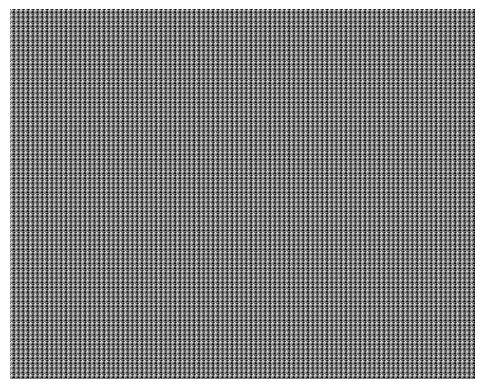

In [78]:
runs1=[]
losses1=[]
for i in range(10): #runnnig kmeans c=1 10 times
    print(datetime.now().strftime("%H:%M:%S"))
    K=KmeanVQ(vecs,'K++',C=1)
    K.run(itt=1000)
    runs1.append(K)
    losses1.append(K.Loss(norm=True))
KBest=runs1[np.argmin(losses1)] #picking best run
print('Lowest Loss:',np.min(losses1)) #print lowest loss
comp=[] 
#rebuilding image
for i in range(len(vecs)):
    comp.append(KBest.mu[int(KBest.labels[i])].reshape(5,5))
for i in range(0,reduced.shape[0],5):
    for j in range(0,reduced.shape[1],5):
        img[i:i+5,j:j+5]=comp.pop(0)
#calculating PSNR        
print('PSNR:',PSNR(np.array(night,dtype='float64'),img*255,data_range=255))
#printing new picture
plt.imshow(img*255,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/Night1.png",bbox_inches='tight',dpi=300)

23:30:16
All Averages Found
Convergence Reached 45  Itterations  22.766640428154166
23:30:20
All Averages Found
Convergence Reached 47  Itterations  22.722176089262426
23:30:24
All Averages Found
Convergence Reached 61  Itterations  22.740322028883252
23:30:30
All Averages Found
Convergence Reached 93  Itterations  22.723523442307094
23:30:38
All Averages Found
Convergence Reached 54  Itterations  22.827033386949992
23:30:43
All Averages Found
Convergence Reached 64  Itterations  22.737669666005978
23:30:49
All Averages Found
Convergence Reached 73  Itterations  22.866246908466756
23:30:55
All Averages Found
Convergence Reached 46  Itterations  22.787932804068767
23:30:59
All Averages Found
Convergence Reached 82  Itterations  22.736741275302627
23:31:06
All Averages Found
Convergence Reached 73  Itterations  22.744426321813744
Lowest Loss: 22.722176089262426
PSNR: 17.667414793275142


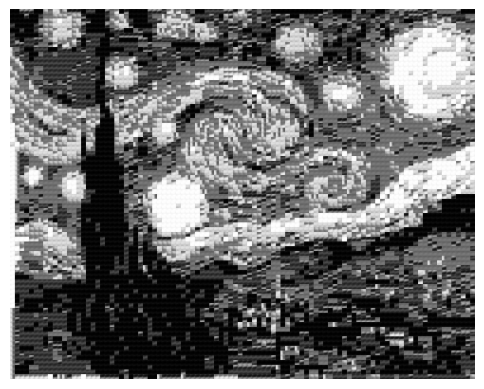

In [80]:
# same as prv cell b ut with C=10
runs10=[]
losses10=[]
for i in range(10):
    print(datetime.now().strftime("%H:%M:%S"))
    K=KmeanVQ(vecs,'K++',C=10)
    K.run(itt=1000)
    runs10.append(K)
    losses10.append(K.Loss(norm=True))
KBest=runs10[np.argmin(losses10)]
print('Lowest Loss:',np.min(losses10))
comp=[]
for i in range(len(vecs)):
    comp.append(KBest.mu[int(KBest.labels[i])].reshape(5,5))
for i in range(0,reduced.shape[0],5):
    for j in range(0,reduced.shape[1],5):
        img[i:i+5,j:j+5]=comp.pop(0)
print('PSNR:',PSNR(np.array(night,dtype='float64'),img*255,data_range=255))
plt.imshow(img*255,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/Night10.png",bbox_inches='tight',dpi=300)

23:39:40
All Averages Found
Convergence Reached 39  Itterations  15.789890338564542
23:40:01
All Averages Found
Convergence Reached 49  Itterations  15.760609367131863
23:40:23
All Averages Found
Convergence Reached 63  Itterations  15.752109758558207
23:40:50
All Averages Found
Convergence Reached 40  Itterations  15.772294996070437
23:41:13
All Averages Found
Convergence Reached 46  Itterations  15.790031383068852
23:41:36
All Averages Found
Convergence Reached 49  Itterations  15.801533610313625
23:42:02
All Averages Found
Convergence Reached 71  Itterations  15.764548581238649
23:42:33
All Averages Found
Convergence Reached 62  Itterations  15.802257428457702
23:43:00
All Averages Found
Convergence Reached 44  Itterations  15.824390540232411
23:43:25
All Averages Found
Convergence Reached 54  Itterations  15.795914253899113
Lowest Loss: 15.752109758558207
PSNR: 19.25852671236476


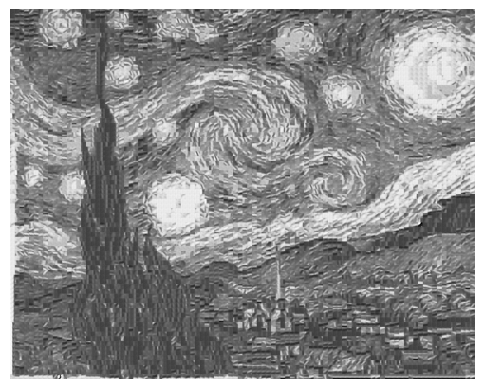

In [83]:
# same as prv cell b ut with C=100
runs100=[]
losses100=[]
for i in range(10):
    print(datetime.now().strftime("%H:%M:%S"))
    K=KmeanVQ(vecs,'K++',C=100)
    K.run(itt=1000)
    runs100.append(K)
    losses100.append(K.Loss(norm=True))
KBest=runs100[np.argmin(losses100)]
print('Lowest Loss:',np.min(losses100))
comp=[]
for i in range(len(vecs)):
    comp.append(KBest.mu[int(KBest.labels[i])].reshape(5,5))
for i in range(0,reduced.shape[0],5):
    for j in range(0,reduced.shape[1],5):
        img[i:i+5,j:j+5]=comp.pop(0)
print('PSNR:',PSNR(np.array(night,dtype='float64'),img*255,data_range=255))
plt.imshow(img*255,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/Night100.png",bbox_inches='tight',dpi=300)

23:49:11
All Averages Found
Convergence Reached 21  Itterations  9.073355805118867
00:28:36
All Averages Found
Convergence Reached 25  Itterations  9.160524889992121
01:06:15
All Averages Found
Convergence Reached 14  Itterations  9.188742022239882
01:43:46
All Averages Found
Convergence Reached 16  Itterations  9.144661571651984
02:21:43
All Averages Found
Convergence Reached 20  Itterations  9.143589363711678
03:00:04
All Averages Found
Convergence Reached 24  Itterations  9.111121062463146
03:38:29
All Averages Found
Convergence Reached 15  Itterations  9.160862710555941
04:16:30
All Averages Found
Convergence Reached 19  Itterations  9.150172517481177
04:54:37
All Averages Found
Convergence Reached 17  Itterations  9.164266567055682
05:32:46
All Averages Found
Convergence Reached 24  Itterations  9.105575812927002
Lowest Loss: 9.073355805118867
PSNR: 21.6542345872515


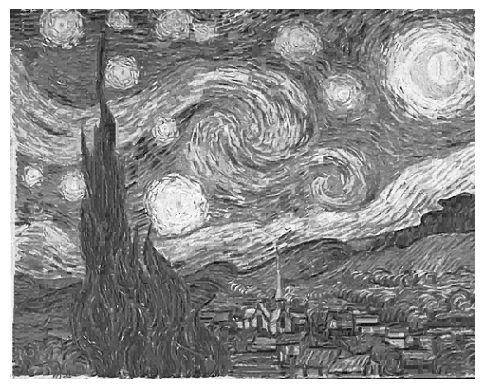

In [84]:
# same as prv cell b ut with C=1000
runs1000=[]
losses1000=[]
for i in range(10):
    print(datetime.now().strftime("%H:%M:%S"))
    K=KmeanVQ(vecs,'K++',C=1000)
    K.run(itt=1000)
    runs1000.append(K)
    losses1000.append(K.Loss(norm=True))
KBest=runs1000[np.argmin(losses1000)]
print('Lowest Loss:',np.min(losses1000))
comp=[]
for i in range(len(vecs)):
    comp.append(KBest.mu[int(KBest.labels[i])].reshape(5,5))
for i in range(0,reduced.shape[0],5):
    for j in range(0,reduced.shape[1],5):
        img[i:i+5,j:j+5]=comp.pop(0)
print('PSNR:',PSNR(np.array(night,dtype='float64'),img*255,data_range=255))
plt.imshow(img*255,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/Night1000.png",bbox_inches='tight',dpi=300)

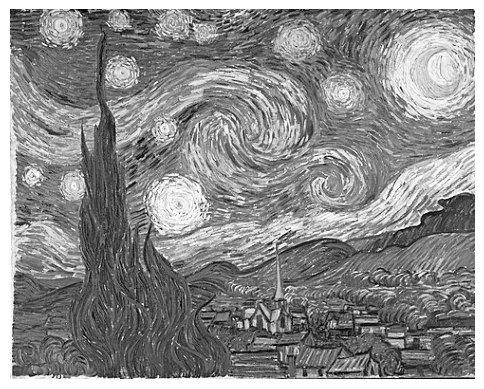

In [4]:
#plpotting orignal image so that is in the same shape and format as other ones
plt.imshow(night,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/NightNonCompress.png",bbox_inches='tight',dpi=300)